# Calculating and plotting isobars and isopleths

## Calculate isobars and isopleths
In this example, we demonstrate how isobars (lines of constant pressure) and isopleths (lines of constant fluid composition) can be calculated for any one composition. A single melt composition can be extracted from a loaded excel file, or a composition can be enterred by hand an stored within a dictionary. Due to computational intensity, isobars and isopleths can only be computed for one sample composition at a time.

Once a single composition is defined, conditions over which to calculate isobars and isopleths must be specified. The generated plot is isothermal, so only one temperature can be chosen. Isobars can be calculated for any number of pressures, passed as a list.

The calculation is performed by iterating through possible concentrations of H$_2$O and CO$_2$ and calculating the equilibrium state for the system. The iteration begins at a fixed H$_2$O concentration, increasing the CO$_2$ concentration in steps of 0.1 wt% until a fluid phase is stable. The H$_2$O concentration is then increased by 0.5 wt% and CO$_2$ is again increased from 0 until a fluid phase is stable. This process is repeated for H$_2$O values ranging from 0–15 wt%. The H$_2$O and CO$_2$ concentrations from each system for which a fluid phase was found to be stable are saved and written to a pandas DataFrame, which is returned upon completion of the calculation.

**Method structure:**<br>
>*Only single-sample calculations.* `def calculate_isobars_and_isopleths(self, sample, temperature, pressure_list, isopleth_list, print_status=False).result`

**Required inputs:**<br>
>`sample`: The sample composition, as a dictionary with values in wt%

>`temperature`: The temperature in $^{\circ}$C. 

>`pressure_list`: A list of all pressures in bars at which to calculate isobars.

**Optional inputs:**<br>
>`isopleth_list`: The default value is None in which case only isobars will be calcualted. A list of all fluid composition values, in mole fraction H$_2$O (XH$_2$O$^{fluid}$), at which to calculate isopleths. Values can range from 0–1.

>`print_status`: The default value is False. If set to `True`, the progress of the calculations will be printed to the terminal.

**Calculated outputs:** 
>The function returns two pandas DataFrames: the first has isobar data, and the second has isopleth data. Columns in the isobar dataframe are 'Pressure', 'H2Omelt', and 'CO2melt', correpsonding to pressure in bars and dissolved H$_2$O and CO$_2$ in the liquid in wt%. Columns in the isopleth dataframe are 'XH2O_fl', 'H2O_liq', and 'CO2_liq', corresponding to XH$_2$O$^{fluid}$ and dissolved H$_2$O and CO$_2$ in the liquid in wt%.

In [1]:
import sys
sys.path.insert(0, '../')

import VESIcal as v

### Import an Excel file and extract a single sample

In [3]:
myfile = v.ExcelFile('../manuscript/example_data.xlsx')
SampleName = 'BT-ex'
extracted_bulk_comp = myfile.get_sample_oxide_comp(SampleName)

### Do the calculation

In [4]:
isobars, isopleths = v.calculate_isobars_and_isopleths(sample=extracted_bulk_comp, 
                                            temperature=1000.0,
                                            pressure_list=[1000.0, 2000.0, 3000.0],
                                            isopleth_list=[0.25,0.5,0.75],
                                            print_status=True).result

Calculating isobar at 1000.0 bars
Calculating isopleth at 0
Calculating isopleth at 0.25
Calculating isopleth at 0.5
Calculating isopleth at 0.75
Calculating isopleth at 1
Calculating isobar at 2000.0 bars
Calculating isopleth at 0
Calculating isopleth at 0.25
Calculating isopleth at 0.5
Calculating isopleth at 0.75
Calculating isopleth at 1
Calculating isobar at 3000.0 bars
Calculating isopleth at 0
Calculating isopleth at 0.25
Calculating isopleth at 0.5
Calculating isopleth at 0.75
Calculating isopleth at 1
Done!


## Plot isobars and isopleths
Once isobars and isopleths are calculated, they can be plotted in an H$_2$O versus CO$_2$ plot with one simple function call. The plot will be printed directly in the notebook or, if the code is run as script in a command line, the plot will appear it its own window, at which point it can be saved as an image file. The `plot_isobars_and_isopleths` function takes in a pandas DataFrame with calculated isobar and isopleth information (e.g., output from calculate_isobars_and_isopleths) and plots data as isobars (lines of constant pressure) and isopleths (lines of constant fluid composition). These lines represent the saturation pressures of the melt composition used to calculate the isobar and isopleth information. 

**Method structure:**<br>
>*Only single-sample calculations.* `def plot_isobars_and_isopleths(self, isobars, isopleths)`

**Required inputs:**<br>
>`isobars`: Pandas DataFrame object containing isobar information as calculated by calculate_isobars_and_isopleths.

>`isopleths`: Pandas DataFrame object containing isopleth information as calculated by calculate_isobars_and_isopleths.

**Calculated outputs:** 
>The function returns a matplotlib object with the x-axis as H2O wt% in the melt and y-axis as CO2 wt% in the melt. Isobars, or lines of constant pressure at which the sample magma composition is saturated, and isopleths, or lines of constant fluid composition at which the sample magma composition is saturated, are plotted.

### Plot your data

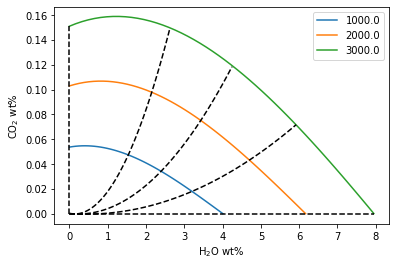

In [5]:
v.plot_isobars_and_isopleths(isobars, isopleths)

### Custom plotting
The user may wish to apply custom formatting to the plot, in which case, an example code to plot isobars and isopleths is provided below.

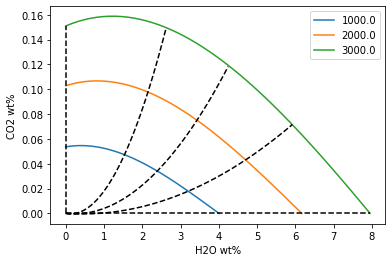

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# #-----------------------CODE TO PLOT ISOBARS AND ISOPLETHS-----------------#
P_vals = isobars.Pressure.unique() #grab all unique pressure values
XH2O_vals = isopleths.XH2O_fl.unique() #grab all unique XH2O values
isobars_lists = isobars.values.tolist() #transform isobar dataframe into a list of lists
isopleths_lists = isopleths.values.tolist() #transform isopleth dataframe into a list of lists

# add zero values to volatiles list
isobars_lists.append([0.0, 0.0, 0.0, 0.0])

# draw the figure
fig, ax1 = plt.subplots()
plt.xlabel('H2O wt%')
plt.ylabel('CO2 wt%')

# do some data smoothing
for pressure in P_vals:
    Pxs = [item[1] for item in isobars_lists if item[0] == pressure]
    Pys = [item[2] for item in isobars_lists if item[0] == pressure]

    try:
        np.seterr(divide='ignore', invalid='ignore') #turn off numpy warning
        ## calcualte polynomial
        Pz = np.polyfit(Pxs, Pys, 3)
        Pf = np.poly1d(Pz)

        ## calculate new x's and y's
        Px_new = np.linspace(Pxs[0], Pxs[-1], 50)
        Py_new = Pf(Px_new)

        # Plot some stuff
        ax1.plot(Px_new, Py_new)
    except:
        ax1.plot(Pxs, Pys)

for Xfl in XH2O_vals:
    Xxs = [item[1] for item in isopleths_lists if item[0] == Xfl]
    Xys = [item[2] for item in isopleths_lists if item[0] == Xfl]

    try:
        ## calcualte polynomial
        Xz = np.polyfit(Xxs, Xys, 2)
        Xf = np.poly1d(Xz)

        ## calculate new x's and y's
        Xx_new = np.linspace(Xxs[0], Xxs[-1], 50)
        Xy_new = Xf(Xx_new)

        # Plot some stuff
        ax1.plot(Xx_new, Xy_new, ls='dashed', color='k')
    except:
        ax1.plot(Xxs, Xys, ls='dashed', color='k')

labels = P_vals
ax1.legend(labels)

np.seterr(divide='warn', invalid='warn') #turn numpy warning back on

plt.show()